Script to combine JSON simulation result files into a unified results structure.

Each input file must follow the naming convention:
    `{name}_sim{sim_id}_{timestamp}.json`

and contain a JSON object with keys:
- scenario_name: str
- sim_id: int
- agent_names: list of str
- cum_regrets: list of lists (one per agent)
- time_agents: list of lists (one per agent)

The script aggregates data across multiple files for the same scenario and sim_id,
producing a `results` dict:

```
results[scenario_name] = {
    "scenario_name": scenario_name,
    "sim_id": [list of sim_ids],
    "regrets": {agent_name: np.ndarray of shape (n_simulations, n_draws)},
    "times": {agent_name: np.ndarray of shape (n_simulations, n_draws)},
}
```

## Pre

In [1]:
import os
import glob
import json
import numpy as np

def load_and_combine(json_dir: str = '.'):
    # Temporary storage: scenario -> sim_id -> list of file data dicts
    files_data = {}

    # Collect and parse all JSON files
    for filepath in glob.glob(os.path.join(json_dir, '*.json')):
        with open(filepath, 'r') as f:
            data = json.load(f)
        scenario = data['scenario_name']
        sim_id = data['sim_id']
        # filter out 'Random' agent except for the first time
        rnd_idx = data['agent_names'].index('Random') if 'Random' in data['agent_names'] else None
        if rnd_idx is not None:
            # if this sim_id already has a 'Random' agent, remove it
            for existing_entry in files_data.get(scenario, {}).get(sim_id, []):
                if 'Random' in existing_entry['agent_names']:
                    data['agent_names'].pop(rnd_idx)
                    data['cum_regrets'] = np.delete(data['cum_regrets'], rnd_idx, axis=1).tolist()
                    data['time_agents'] = np.delete(data['time_agents'], rnd_idx, axis=1).tolist()
                    break
        files_data.setdefault(scenario, {}).setdefault(sim_id, []).append({
            'agent_names': data['agent_names'],
            'cum_regrets': data['cum_regrets'],
            'time_agents': data['time_agents'],
        })

    results = {}
    # Combine per scenario
    for scenario_name, sim_dict in files_data.items():
        # Determine all unique agent names
        all_agents = sorted({name for entries in sim_dict.values() for e in entries for name in e['agent_names']})

        # Simulation IDs sorted
        sim_ids = sorted(sim_dict.keys())
        n_simulations = max(sim_ids) + 1
        # Determine number of draws from the first entry
        sample = sim_dict[sim_ids[0]][0]
        n_draws = len(sample['cum_regrets'])

        # Allocate arrays for each agent
        all_regrets = {name: np.zeros((n_simulations, n_draws)) for name in all_agents}
        all_times   = {name: np.zeros((n_simulations, n_draws)) for name in all_agents}

        # Fill arrays with transposed data (draws × agents -> agents × draws)
        for sim_id, entries in sim_dict.items():
            for entry in entries:
                cum_regs = np.array(entry['cum_regrets'])   # shape: (n_draws, n_agents)
                time_ag  = np.array(entry['time_agents'])   # shape: (n_draws, n_agents)
                for i, name in enumerate(entry['agent_names']):
                    all_regrets[name][sim_id, :] = cum_regs[:, i]
                    all_times[name][sim_id, :]   = time_ag[:, i]

        # Build scenario's combined results
        results[scenario_name] = {
            'scenario_name': scenario_name,
            'sim_id': sim_ids,
            'regrets': all_regrets,
            'times': all_times,
        }

    return results

In [2]:
combined = load_and_combine('./results/compare_all')

In [3]:
from compare_agents import print_summary_results, print_topn_agents_per_scenario, print_pairwise_win_tie_lose, print_relative_performance, plot_print_total_regret_factors, print_relative_performance, plot_comparison_results

In [4]:
combined = {k: combined[k] for k in [
    # "Linear",
    # "Friedman",
    # "LinFriedman",
    # "Friedman2",
    # "Friedman3",
    "Magic",
    "Shuttle",
    "Adult",
    "Mushroom",
    # "Iris",
    # "Wine",
    # "Heart"
    ] if k in combined}

## Printed Info

In [5]:
print_summary_results(combined)


=== Magic Scenario ===

Final cumulative regrets (mean ± std):
                Agent  Mean Regret  Std Regret
                BARTm      1929.50      281.65
         BARTm_tree2x      1949.88      321.42
                BARTo      1786.38      126.62
         BARTo_tree2x      1801.38      138.78
                BARTs      1599.88       36.07
         BARTs_tree2x      1605.88       44.43
             LinearTS      2191.00       28.14
                 RFTS      1585.50       27.14
               Random      4965.62       42.22
         RefreshBARTm      1563.00       28.57
RefreshBARTm_iter0.5x      1555.25       27.55
  RefreshBARTm_tree2x      1562.00       18.06
         RefreshBARTo      1594.75       33.72
RefreshBARTo_iter0.5x      1607.62       28.44
  RefreshBARTo_tree2x      1639.38       31.69
         RefreshBARTs      1516.62       30.85
RefreshBARTs_iter0.5x      1527.38       29.96
  RefreshBARTs_tree2x      1525.50       35.03
            XGBoostTS      1583.00       37

In [6]:
print_topn_agents_per_scenario(combined, 5)


Top 5 agents per scenario:
                        Magic                Shuttle                  Adult             Mushroom
Rank 1           RefreshBARTs  RefreshBARTm_iter0.5x    RefreshBARTs_tree2x         BARTs_tree2x
Rank 2    RefreshBARTs_tree2x    RefreshBARTm_tree2x  RefreshBARTs_iter0.5x  RefreshBARTs_tree2x
Rank 3  RefreshBARTs_iter0.5x           RefreshBARTm              XGBoostTS         RefreshBARTs
Rank 4  RefreshBARTm_iter0.5x    RefreshBARTs_tree2x    RefreshBARTm_tree2x  RefreshBARTm_tree2x
Rank 5    RefreshBARTm_tree2x  RefreshBARTs_iter0.5x           RefreshBARTs         RefreshBARTm


In [7]:
print_pairwise_win_tie_lose(combined)


Totals across all scenarios (sorted by win*3+tie):
                       win  tie  lose
RefreshBARTs_tree2x     39   51     0
RefreshBARTs_iter0.5x   38   52     0
RefreshBARTs            38   51     1
RefreshBARTm_iter0.5x   35   54     1
RefreshBARTm_tree2x     33   54     3
RefreshBARTm            30   57     3
XGBoostTS               29   50    11
BARTs_tree2x            25   53    12
RFTS                    21   59    10
BARTs                   22   55    13
RefreshBARTo            15   58    17
RefreshBARTo_iter0.5x   14   55    21
RefreshBARTo_tree2x     13   48    29
BARTm_tree2x            14   43    33
BARTm                   13   42    35
BARTo                    7   48    35
BARTo_tree2x             7   48    35
LinearTS                 4   21    65
Random                   0   17    73


In [8]:
print_relative_performance(combined)


Agent performance (relative to LinearTS):
Agent                         Mean       SE Std (stability)
-----------------------------------------------------------
RefreshBARTm_iter0.5x        0.166    0.194    0.388
RefreshBARTs_tree2x          0.169    0.190    0.379
RefreshBARTm_tree2x          0.170    0.193    0.386
RefreshBARTm                 0.175    0.193    0.387
RefreshBARTs                 0.183    0.188    0.375
RefreshBARTs_iter0.5x        0.190    0.186    0.373
BARTs_tree2x                 0.195    0.194    0.389
XGBoostTS                    0.220    0.184    0.368
RFTS                         0.281    0.170    0.339
BARTs                        0.298    0.163    0.326
BARTm_tree2x                 0.332    0.181    0.361
BARTm                        0.341    0.179    0.359
RefreshBARTo                 0.377    0.162    0.324
RefreshBARTo_iter0.5x        0.449    0.148    0.296
RefreshBARTo_tree2x          0.479    0.154    0.308
BARTo_tree2x                 0.531    0.16

In [9]:
print_relative_performance(combined, "times")


Agent performance (relative to LinearTS):
Agent                         Mean       SE Std (stability)
-----------------------------------------------------------
Random                       0.141    0.008    0.016
LinearTS                     1.658    0.089    0.177
BARTs                       74.717    5.759   11.517
BARTo                      104.782   32.039   64.078
RefreshBARTs_iter0.5x      114.575   12.284   24.569
XGBoostTS                  114.690    5.201   10.402
BARTm                      122.558   93.108  186.215
RefreshBARTo_iter0.5x      123.967    2.832    5.663
BARTs_tree2x               134.628    2.848    5.696
RefreshBARTm_iter0.5x      138.513    6.697   13.394
RFTS                       165.631   34.835   69.670
BARTo_tree2x               184.470   31.948   63.897
BARTm_tree2x               218.147  103.167  206.334
RefreshBARTs               227.166   22.077   44.153
RefreshBARTo               246.992    6.189   12.378
RefreshBARTm               277.060   15.00

## Plot & Print

In [10]:
plot_print_total_regret_factors(combined)


Mean relative regret by "Model" category (rows) and scenario (columns):
                m        o        s
Adult    1640.325 1801.150 1590.575
Average     0.008    0.008    0.008
Magic    1711.925 1685.900 1555.050
Mushroom   60.425  193.825   55.700
Shuttle   432.500  484.475  244.150

Mean relative regret by "Tree" category (rows) and scenario (columns):
               1x       2x
Adult    1658.646 1721.625
Average     0.008    0.008
Magic    1665.021 1680.667
Mushroom  104.229  102.396
Shuttle   470.792  387.312

Mean relative regret by "Iter" category (rows) and scenario (columns):
             0.5x       1x
Adult    1626.208 1618.625
Average     0.009    0.008
Magic    1563.417 1558.125
Mushroom  103.333   85.667
Shuttle   219.000  201.917

Mean relative regret by "MC" category (rows) and scenario (columns):
Empty DataFrame
Columns: []
Index: []

Mean relative regret by "Refresh" category (rows) and scenario (columns):
               no      yes
Adult    1741.021 1639.250
Averag

## "Beautiful" Plots

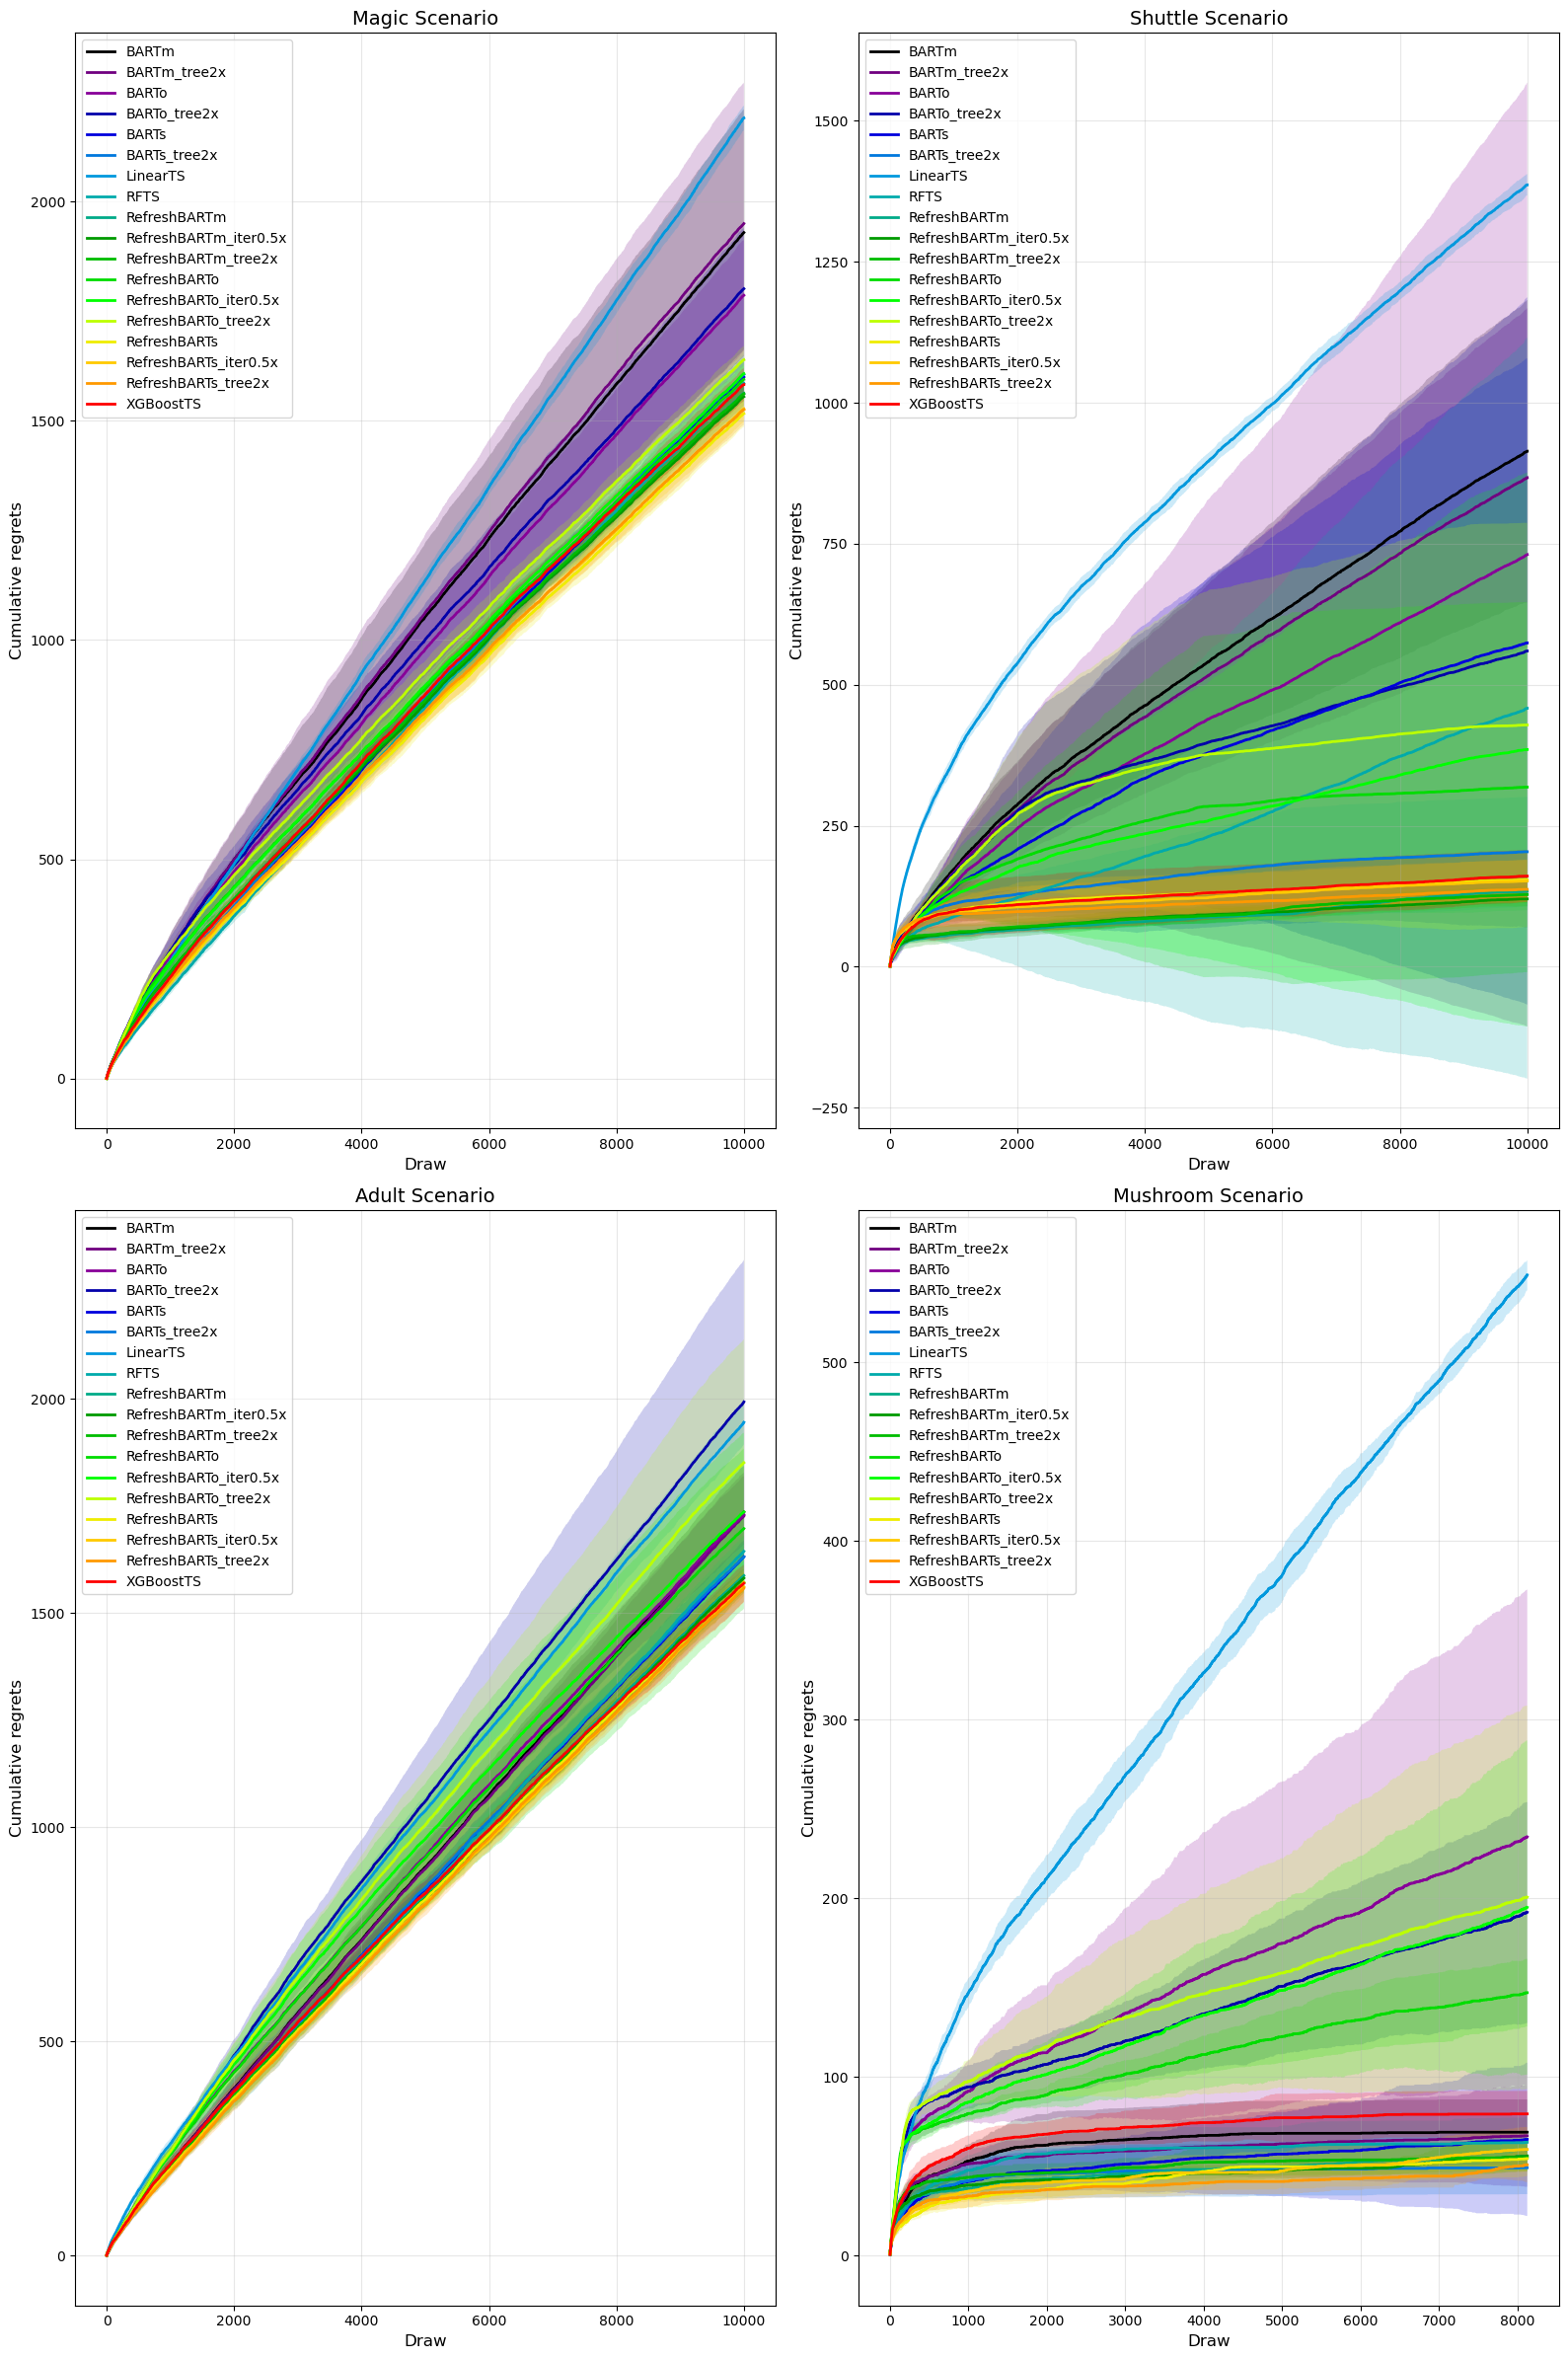

In [11]:
plot_comparison_results(combined, show_random=False)

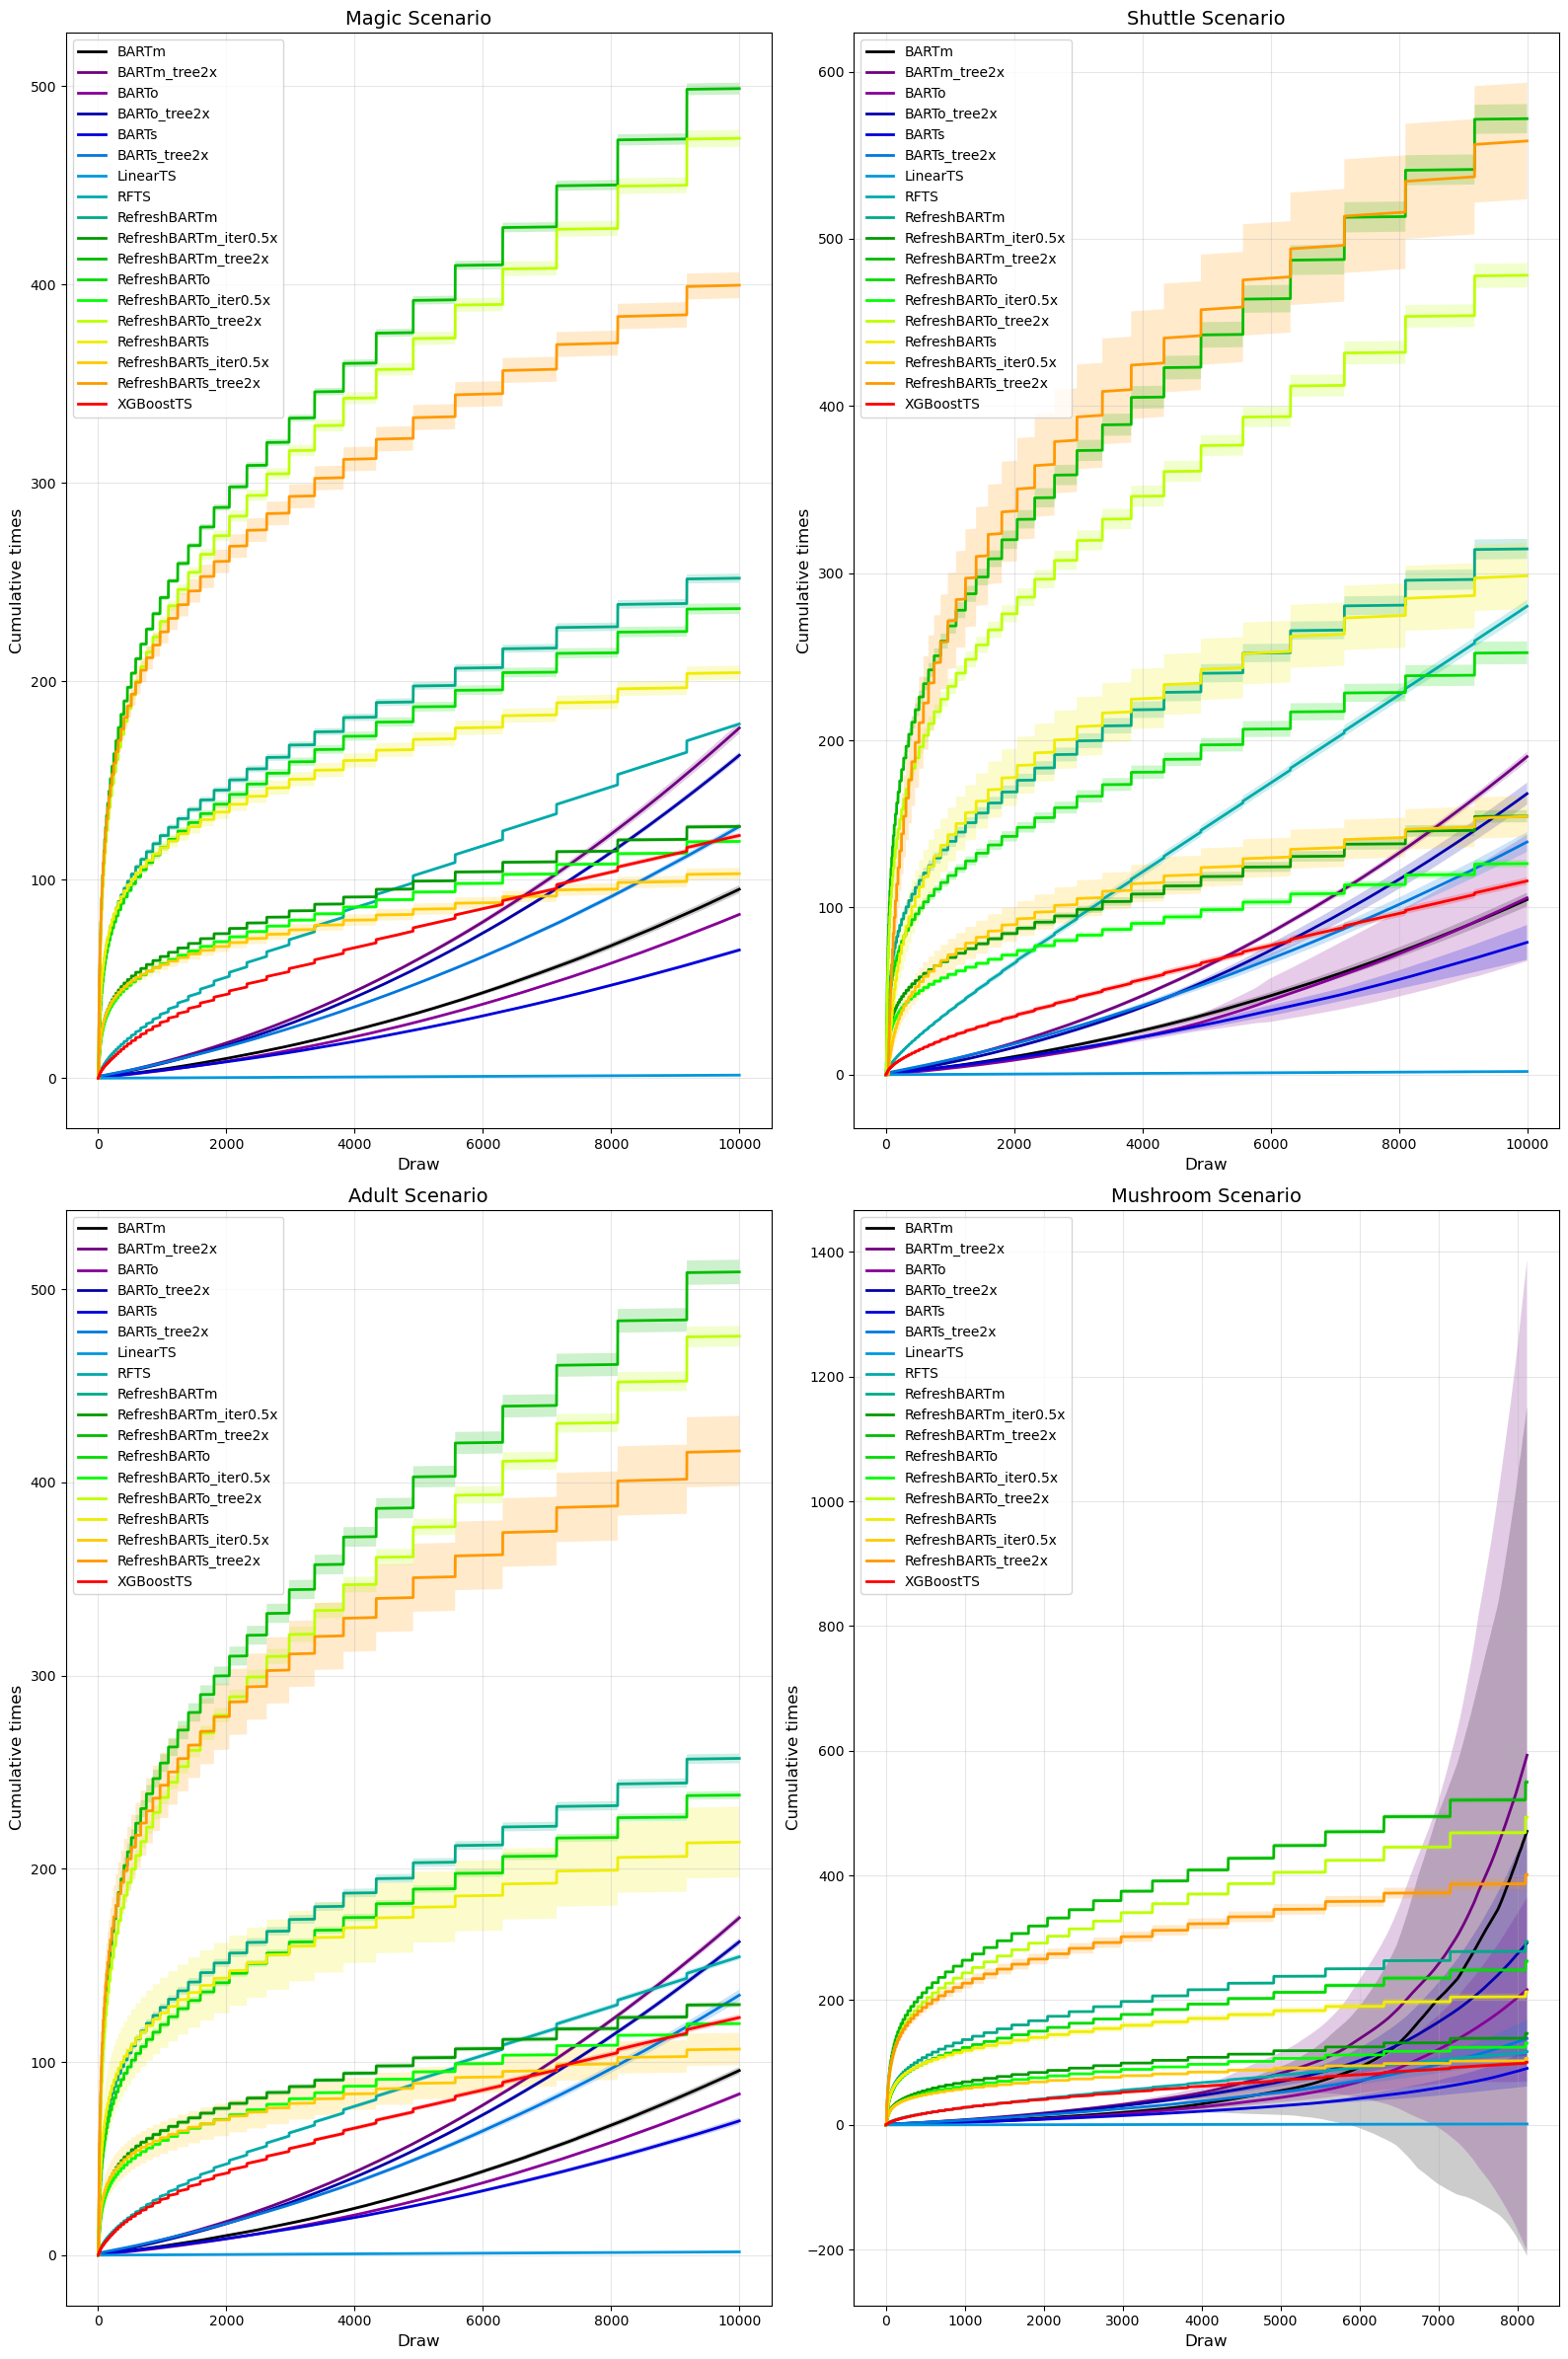

In [12]:
plot_comparison_results(combined, show_random=False, target="times")